In [1]:
from importlib import reload
import sys
import pickle
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pybedtools
from joblib import Parallel, delayed
import get_feature_matrix_perchr as gfm
from tqdm import tqdm
import time

In [2]:
# Reload modules in case of modifications
reload(gfm)

<module 'get_feature_matrix_perchr' from '/home/louiscam/projects/gpcr/code/epigenome_processing/get_feature_matrix_perchr.py'>

# Data directories

In [3]:
genome_dir = '/home/louiscam/projects/gpcr/data/genome_data/'
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data_targetfinder/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'

In [4]:
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Create dataframe of regulatory marks for loci

In [5]:
# Get dataframe of available regulatory marks
df = pd.read_csv(epigenome_dir+'filenames_belyaeva.csv', sep=',', header=0)

In [6]:
# Get chromosome sizes
df_sizes = gfm.get_chrom_sizes(genome_dir, resol)

In [7]:
# Divide genome into portions corresponding to loci
chr_list = np.arange(1,22+1)
df_chrom_list = []
for chrom in chr_list:
    # Get chromosome size
    chrom_size = int(df_sizes.loc[df_sizes['chr']==str(chrom)]['size'])
    # Divide the chromosome into segments of HIC_RESOLN length
    stop_pos = np.arange(resol, chrom_size + resol, resol, dtype = 'int')
    df_chrom = pd.DataFrame()
    df_chrom['chrom'] = ['chr' + str(chrom)]*len(stop_pos)
    df_chrom['start'] = stop_pos - resol
    df_chrom['stop'] = stop_pos
    df_chrom_list.append(df_chrom)
all_loci_pos = pd.concat(df_chrom_list, axis=0)

In [8]:
# Create dataframe of loci location
all_loci_loc = all_loci_pos.copy()
all_loci_loc['chrom'] = all_loci_loc['chrom'].str.strip('chr').astype(int)
all_loci_loc['locus'] = ['chr_'+str(all_loci_loc.iloc[i]['chrom'])+'_loc_'+str(all_loci_loc.iloc[i]['start'])
                          for i in range(all_loci_loc.shape[0])]
all_loci_loc.columns = ['#chrom', 'chromStart', 'chromEnd', 'locus']
all_loci_loc = all_loci_loc[['locus', '#chrom', 'chromStart', 'chromEnd']]
all_loci_loc['locusLength'] = resol
all_loci_loc.columns = ['locus','chrom','start','end','length']
all_loci_loc = all_loci_loc.sort_values(by=['chrom','start'])
all_loci_loc.head()

,locus,chrom,start,end,length
0,chr_1_loc_0,1,0,250000,250000
1,chr_1_loc_250000,1,250000,500000,250000
2,chr_1_loc_500000,1,500000,750000,250000
3,chr_1_loc_750000,1,750000,1000000,250000
4,chr_1_loc_1000000,1,1000000,1250000,250000


In [13]:
# Convert to bed file
bed_all_loci = pybedtools.BedTool.from_dataframe(all_loci_pos)
bed_all_loci = bed_all_loci.sort()
bed_all_loci_df = bed_all_loci.to_dataframe()

In [14]:
# Process all epigenomic features
for i in range(len(df)):
    f = df.iloc[i]['filename']
    feature = df.loc[i,'name']
    print('Process '+feature)
    # Get bed file of the feature
    bed = pybedtools.BedTool(epigenome_dir + f).sort()
    # Get counts for this feature and this chromosome
    out = pybedtools.bedtool.BedTool.map(bed_all_loci, bed, c = [2,3], o = 'count_distinct')
    counts = out.to_dataframe()['name'].values
    # Store results into matrix
    all_loci_loc[feature] = counts
    # Normalize by locus length
    all_loci_loc['norm_'+feature] = np.log(1+1000000*all_loci_loc[feature]/resol)
    # z-score
    mean = all_loci_loc['norm_'+feature].mean()
    std = all_loci_loc['norm_'+feature].std()
    all_loci_loc['z_'+feature] = (all_loci_loc['norm_'+feature]-mean)/std

Process RNAseq


In [16]:
# Normalize epigenomic features
all_loci_loc = all_loci_loc[[col for col in all_loci_loc.columns if ('z_' in col) or (col == 'locus')]]
all_loci_loc = all_loci_loc.set_index('locus').transpose()
all_loci_loc = all_loci_loc.sort_index(axis=1)
all_loci_loc.index = all_loci_loc.index.str.strip('z_')

# Determine active and inactive regions

### Load epigenomic data

In [10]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'_norm.csv', header=0, index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_norm],axis=1)
df_all_norm

,chr_1_loc_0,chr_1_loc_250000,chr_1_loc_500000,chr_1_loc_750000,chr_1_loc_1000000,chr_1_loc_1250000,chr_1_loc_1500000,chr_1_loc_1750000,chr_1_loc_2000000,chr_1_loc_2250000,...,chr_22_loc_49000000,chr_22_loc_49250000,chr_22_loc_49500000,chr_22_loc_49750000,chr_22_loc_50000000,chr_22_loc_50250000,chr_22_loc_50500000,chr_22_loc_50750000,chr_22_loc_51000000,chr_22_loc_51250000
H3K4me1,-1.008735,-2.015639,-0.505283,0.796121,0.699133,0.699133,0.765209,0.699133,0.645307,0.868093,...,-2.015639,-1.512187,-2.015639,-2.015639,0.322319,0.663696,0.920941,0.699133,0.780829,-2.015639
H3K4me2,-1.958933,-1.958933,-0.780395,0.903726,0.629325,0.777549,0.960422,1.110838,1.155592,0.587846,...,-1.958933,-1.369664,-1.958933,-1.958933,0.398144,0.706663,0.706663,0.842976,0.668873,-1.958933
H3K4me3,-0.762508,-1.559915,-0.296056,2.096163,2.047202,2.188246,1.942547,1.629711,2.096163,1.555465,...,-1.559915,-0.762508,-1.559915,-1.559915,1.089012,1.555465,2.096163,1.699454,2.047202,-1.559915
H3K36me3,-0.846516,-1.915456,0.502253,1.085439,0.909434,0.732414,1.053306,0.966577,0.947996,0.756895,...,-0.221226,0.119462,-0.312046,-0.221226,0.269171,0.756895,0.825993,0.780622,1.019776,-1.915456
H3K9ac,-2.030991,-3.572735,-1.408623,1.086720,1.328125,1.152158,1.381093,1.314479,1.152158,1.286674,...,-1.129128,-1.011953,-1.011953,-1.260118,0.635789,0.709143,1.183488,1.341605,0.943019,-3.572735
POLR2A,-0.789470,-0.789470,0.148832,3.123182,2.327504,2.456524,1.636007,1.389201,2.456524,1.636007,...,-0.789470,-0.789470,-0.789470,-0.789470,1.636007,1.636007,1.389201,2.184879,0.148832,-0.789470
H3K9me3,-4.012477,-6.973887,-3.677000,-0.596838,-0.485287,-1.461657,-1.556038,0.620154,-0.485287,-0.329699,...,-1.655523,-1.126180,-1.556038,-1.655523,-0.186247,0.030477,-0.186247,-1.051067,0.260780,-6.973887
H3K27me3,-0.207024,-1.800421,-1.297760,0.641495,0.407424,0.295636,-0.501062,0.407424,0.372042,0.562305,...,-1.800421,-1.800421,-1.800421,-1.297760,0.562305,0.210222,0.616047,0.254186,0.798297,-1.800421
RNAseq,-0.580582,-1.212921,0.481148,1.608928,1.932739,1.820298,1.605801,1.055406,0.703510,1.027435,...,-0.630660,-0.515558,-1.436824,-1.274597,0.548814,1.118235,1.479756,1.333030,0.878212,-1.991482
ATACseq,-0.649909,-1.994005,-1.994005,1.160163,1.077385,1.148882,1.051953,0.844721,0.984326,0.925460,...,-1.474038,-1.994005,-0.534272,1.038907,0.984326,1.113985,1.077385,-0.434103,-1.994005,-1.994005


### Hierarchical clustering

In [7]:
# Hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(df_all_norm.T)
print('Total number of loci = '+str(len(clustering.labels_)))
print('Number of loci in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of loci in cluster 1 = '+str(np.sum(clustering.labels_==1)))

Total number of loci = 11537
Number of loci in cluster 0 = 5085
Number of loci in cluster 1 = 6452


In [8]:
# PCA
pca = PCA(n_components=2)
PCs = pca.fit_transform(df_all_norm.T)

In [9]:
# tSNE
tsne = TSNE(n_components=2)
tSNEs = tsne.fit_transform(df_all_norm.T)

In [93]:
# Add cluster, pca and tSNE coordinates to data
df_clusters = df_all_norm.T
df_clusters['cluster'] = clustering.labels_
df_clusters['PC1'] = PCs[:,0]
df_clusters['PC2'] = PCs[:,1]
df_clusters['tSNE1'] = tSNEs[:,0]
df_clusters['tSNE2'] = tSNEs[:,1]
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,18.637463,-47.233109
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,36.665329,-51.088432
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,15.004036,-42.209999
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,55.177624,62.523865
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,54.453098,59.735138


### Add adhesome loci information

In [94]:
# Load adhesome loci
adhesome_loci = pickle.load(open('adhesome_loci.pkl', 'rb'))
adhesome_loci = np.unique(adhesome_loci['locus_id'].values)
n_adhesome = len(adhesome_loci)

In [95]:
# Add column to df_clusters
df_clusters['adhesome_locus'] = 0
df_clusters.loc[adhesome_loci,'adhesome_locus'] = 1
pickle.dump(df_clusters, open(processed_epigenome_data_dir+'active_inactive_loci.pkl', 'wb'))
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,18.637463,-47.233109,0
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,36.665329,-51.088432,0
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,15.004036,-42.209999,0
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,55.177624,62.523865,0
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,54.453098,59.735138,0


In [54]:
# Number of active/inactive adhesome loci
n_adhesome_active = len(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)])
n_adhesome_inactive = len(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)])

### Plot clusters

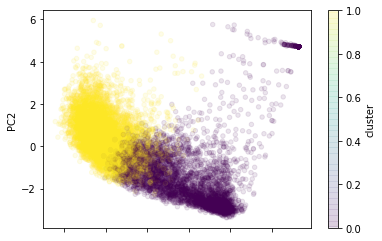

In [38]:
# Plot PC1 and PC2
%matplotlib inline
df_clusters.plot.scatter(x='PC1', y='PC2', c='cluster', colormap='viridis', alpha=0.1)

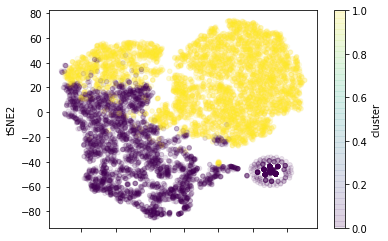

In [39]:
# Plot tSNE1 and tSNE2
%matplotlib inline
df_clusters.plot.scatter(x='tSNE1', y='tSNE2', c='cluster', colormap='viridis', alpha=0.1)

### Plot histogram of features

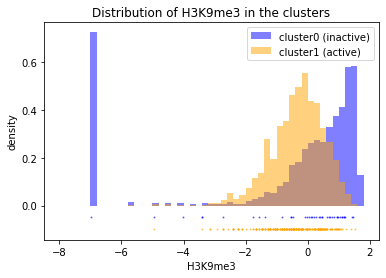

In [77]:
# Distribution of H3K9me3 in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['H3K9me3'], bins=np.arange(-8,2,0.2), 
         color='blue', alpha=0.5, density=True, label='cluster0 (inactive)')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['H3K9me3'], bins=np.arange(-8,2,0.2), 
         color='orange', alpha=0.5, density=True, label='cluster1 (active)')
plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['H3K9me3'], 
            np.zeros(n_adhesome_inactive)-0.05, color='blue', alpha=0.5, s=1)
plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['H3K9me3'], 
            np.zeros(n_adhesome_active)-0.1, color='orange', alpha=0.5, s=1)
plt.xlabel('H3K9me3')
plt.ylabel('density')
plt.title('Distribution of H3K9me3 in the clusters')
plt.legend(loc='upper right')
plt.show()

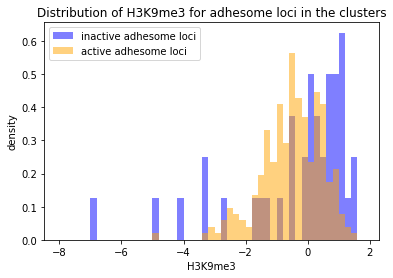

In [79]:
# Distribution of H3K9me3 in clusters for adhesome loci only
%matplotlib inline
plt.figure()
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['H3K9me3'], bins=np.arange(-8,2,0.2), 
         color='blue', alpha=0.5, density=True, label='inactive adhesome loci')
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['H3K9me3'], bins=np.arange(-8,2,0.2), 
         color='orange', alpha=0.5, density=True, label='active adhesome loci')
plt.xlabel('H3K9me3')
plt.ylabel('density')
plt.title('Distribution of H3K9me3 for adhesome loci in the clusters')
plt.legend(loc='upper left')
plt.show()

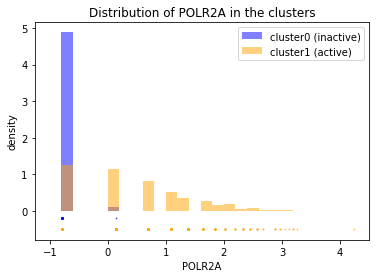

In [80]:
# Distribution of POLR2A in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['POLR2A'], bins=np.arange(-1,4,0.2), 
         color='blue', alpha=0.5, density=True, label='cluster0 (inactive)')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['POLR2A'], bins=np.arange(-1,4,0.2), 
         color='orange', alpha=0.5, density=True, label='cluster1 (active)')
plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['POLR2A'], 
            np.zeros(n_adhesome_inactive)-0.2, color='blue', alpha=0.5, s=1)
plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['POLR2A'], 
            np.zeros(n_adhesome_active)-0.5, color='orange', alpha=0.5, s=1)
plt.xlabel('POLR2A')
plt.ylabel('density')
plt.title('Distribution of POLR2A in the clusters')
plt.legend(loc='upper right')
plt.show()

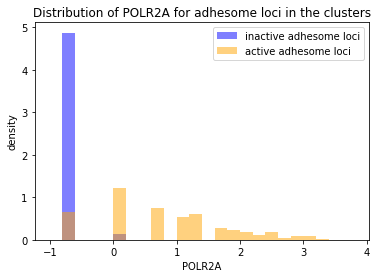

In [83]:
# Distribution of POLR2A in clusters for adhesome loci only
%matplotlib inline
plt.figure()
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['POLR2A'], bins=np.arange(-1,4,0.2), 
         color='blue', alpha=0.5, density=True, label='inactive adhesome loci')
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['POLR2A'], bins=np.arange(-1,4,0.2), 
         color='orange', alpha=0.5, density=True, label='active adhesome loci')
plt.xlabel('POLR2A')
plt.ylabel('density')
plt.title('Distribution of POLR2A for adhesome loci in the clusters')
plt.legend(loc='upper right')
plt.show()

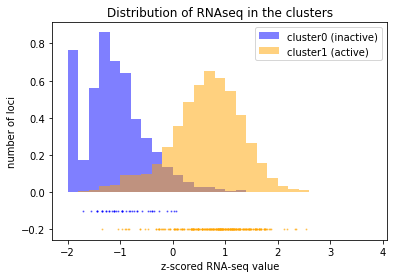

In [84]:
# Distribution of RNAseq in clusters
%matplotlib inline
plt.figure()
plt.hist(df_clusters.loc[df_clusters['cluster']==0]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='blue', alpha=0.5, density=True, label='cluster0 (inactive)')
plt.hist(df_clusters.loc[df_clusters['cluster']==1]['RNAseq'], bins=np.arange(-2,4,0.2), 
         color='orange', alpha=0.5, density=True, label='cluster1 (active)')
plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['RNAseq'], 
            np.zeros(n_adhesome_inactive)-0.1, color='blue', alpha=0.5, s=1)
plt.scatter(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['RNAseq'], 
            np.zeros(n_adhesome_active)-0.2, color='orange', alpha=0.5, s=1)
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('number of loci')
plt.title('Distribution of RNAseq in the clusters')
plt.legend(loc='upper right')
plt.show()

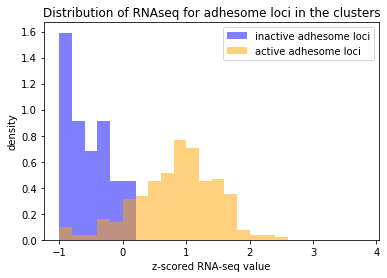

In [86]:
# Distribution of RNA-seq in clusters for adhesome loci only
%matplotlib inline
plt.figure()
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==0)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='blue', alpha=0.5, density=True, label='inactive adhesome loci')
plt.hist(df_clusters[(df_clusters['adhesome_locus']==1) & (df_clusters['cluster']==1)]['RNAseq'], bins=np.arange(-1,4,0.2), 
         color='orange', alpha=0.5, density=True, label='active adhesome loci')
plt.xlabel('z-scored RNA-seq value')
plt.ylabel('density')
plt.title('Distribution of RNAseq for adhesome loci in the clusters')
plt.legend(loc='upper right')
plt.show()

In [87]:
# Define active loci as loci in cluster 1
active_loci = list(df_clusters[df_clusters['cluster']==1].index)
print(len(active_loci))
print(active_loci[0:10])

6452
['chr_1_loc_750000', 'chr_1_loc_1000000', 'chr_1_loc_1250000', 'chr_1_loc_1500000', 'chr_1_loc_1750000', 'chr_1_loc_2000000', 'chr_1_loc_2250000', 'chr_1_loc_2500000', 'chr_1_loc_3000000', 'chr_1_loc_3250000']


# Active and inactive adhesome loci

In [88]:
# Load adhesome loci
adhesome_chr_loci = pd.read_csv(dir_adhesome+'adhesome_loci.csv', header=0, index_col=0)
adhesome_chr_loci.head()

,chrom,chrom_int,loci,gene
34,chr1,1,65,FBLIM1
97,chr1,1,96,ASAP3
173,chr1,1,110,SLC9A1
158,chr1,1,128,FABP3
139,chr1,1,159,MACF1


In [89]:
# Add locus ID column
adhesome_chr_loci['locus_id'] = ['chr_'+str(adhesome_chr_loci.iloc[i]['chrom_int'])+'_loc_'
                                 +str(adhesome_chr_loci.iloc[i]['loci']*resol) 
                                 for i in range(len(adhesome_chr_loci))]
adhesome_chr_loci.head()

,chrom,chrom_int,loci,gene,locus_id
34,chr1,1,65,FBLIM1,chr_1_loc_16250000
97,chr1,1,96,ASAP3,chr_1_loc_24000000
173,chr1,1,110,SLC9A1,chr_1_loc_27500000
158,chr1,1,128,FABP3,chr_1_loc_32000000
139,chr1,1,159,MACF1,chr_1_loc_39750000


In [90]:
# Add activity column
adhesome_chr_loci['active'] = [adhesome_chr_loci.iloc[i]['locus_id'] in active_loci 
                               for i in range(len(adhesome_chr_loci))]
adhesome_chr_loci.to_csv('adhesome_loci_activity.csv', header=True)
adhesome_chr_loci.head()

,chrom,chrom_int,loci,gene,locus_id,active
34,chr1,1,65,FBLIM1,chr_1_loc_16250000,True
97,chr1,1,96,ASAP3,chr_1_loc_24000000,True
173,chr1,1,110,SLC9A1,chr_1_loc_27500000,True
158,chr1,1,128,FABP3,chr_1_loc_32000000,True
139,chr1,1,159,MACF1,chr_1_loc_39750000,True


In [91]:
# Basic statistics
print('Number of active adhesome loci = '+str(adhesome_chr_loci['active'].sum()))
print('Number of inactive adhesome loci = '+str(len(adhesome_chr_loci)-adhesome_chr_loci['active'].sum()))


Number of active adhesome loci = 264
Number of inactive adhesome loci = 41


<Figure size 432x288 with 0 Axes>

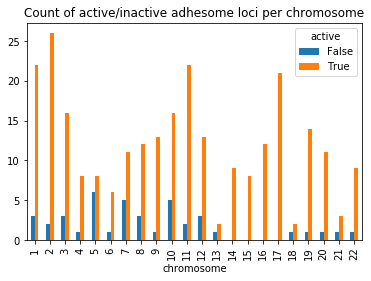

In [92]:
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci.groupby(['chrom_int'])
df_bar1 = df_bar['active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='Count of active/inactive adhesome loci per chromosome')
plt.xlabel('chromosome')
plt.show()